In [4]:
import numpy as np
from scipy import integrate
import math
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE
import time
from tqdm import trange
from environment import *

In [5]:
#import data
import pandas as pd
tcga_all=pd.read_csv('tcga_all.csv')

#init environment
env= environment()

# initialize r_l
num_cases=len(tcga_all)
r_l=np.ones(num_cases)*0.1

# target tcd8+ cells proportion
tcd8_target=tcga_all['tcd8_pop'][:num_cases]

#init running time
tcga_all['time']=int(600)

In [13]:

def opt_fix_para(r_l,jc_scale,h,q,num_cases,tcd8_target):
    cd8_l=[]
    time_l=[]
    for i in trange(num_cases):
        mu=tcga_all.loc[i,'mu']
        r=r_l[i]
        jc=tcga_all.loc[i,'mhc_norm']
        jc_=(1-np.exp(-jc*jc_scale))/(1+np.exp(-jc*jc_scale))
        R_L_prop=tcga_all.loc[i,'Treg_pro']
        tumor=tcga_all.loc[i,'tumor_size']
        a=tcga_all.loc[i,'a']
        ar_ratio=tcga_all.loc[i,'ar_ratio']
        t1=int(tcga_all.loc[i,'time'])
        
        x_=env.fit_pre_treatment(mu,r,jc_,R_L_prop,h,q,a,ar_ratio,t1)
        j=cal_time(x_,tumor)
        cd8_pred=min(x_[j][2]/(x_[j][0]+x_[j][1]),0.1)
        cd8_l.append(cd8_pred)
#         print(int(j/24)+10,x_[j])
        time_l.append(int(j/24)+10)
    return MAE(cd8_l,tcd8_target),cd8_l,time_l
def cal_time(x_,tumor):
    for i in range(len(x_.T[0])):
        if x_.T[0][i]+x_.T[1][i]>tumor:
            break
    return i

In [ ]:
#maximization step: given hidden parameter r, maximize the j1_scale, h, q
test_range=[]
for j1_scale in [2,4,6,8]:
    for h in range(1,4):
        for q in range(1,4):
            test_range.append((j1_scale,h*1e-2,q*1e-2))


# first round, the minimum mae 0.009506 with (j1_scale,h,q)= 6 0.01 0.03
for j1_scale,h,q in test_range:
    mae, cd8_l,time_l = opt_fix_para(r_l,j1_scale,h,q,num_cases,tcd8_target)
    tcga_all['time']=time_l
    print(j1_scale,h,q,mae)

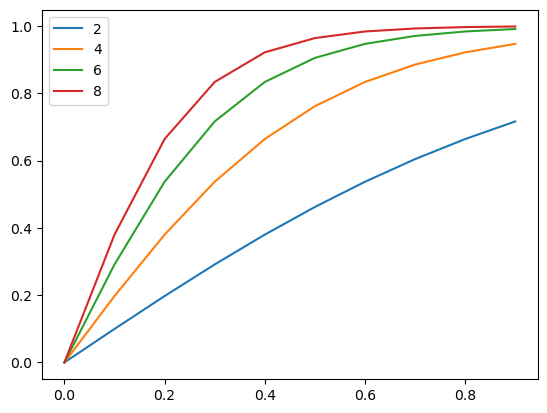

In [40]:
import matplotlib.pyplot as plt
import numpy as np
x=np.arange(10)*0.1
for ind in [2,4,6,8]:
    y=(1 - np.exp(-x* ind)) / (1 + np.exp(-x * ind))
    plt.plot(x,y,label=str(ind))
plt.legend()
plt.show()

In [ ]:
class adjust_r():
    def __init__(self,jc_scare,h,q):
        self.jc_scare=jc_scare
        self.h = h
        self.q = q
        self.env=environment()

    def down_adjust(self, cd8_target, r_origin, error_origin,mu,j1,R_L_prop,a,ar_ratio,tumor,t1):
        r_last = r_origin
        error_last = error_origin
        error = error_origin
        while error <= error_last:
            r = r_last - 0.002
            jc_ = (1 - np.exp(-j1 * self.jc_scare)) / (1 + np.exp(-j1 * self.jc_scare))
            x_ =self.env.fit_pre_treatment(mu, r, jc_, R_L_prop,  self.h,self.q,a,ar_ratio,t1)
            j = cal_time(x_, tumor)
            cd8_pred = min(x_[j][2] / (x_[j][0] + x_[j][1]), 1)

            error_last = error
            error = np.abs(cd8_pred - cd8_target)
#             print(error,cd8_pred,cd8_target)
            r_last = r
            print(error,error_last,cd8_pred,cd8_target,r)
        return r + 0.002


    def up_adjust(self, cd8_target, r_origin, error_origin,mu,j1,R_L_prop,a,ar_ratio,tumor,t1):
        r_last = r_origin
        error_last = error_origin
        error = error_origin
        while error <= error_last:
            r = r_last + 0.002
            jc_ = (1 - np.exp(-j1 * self.jc_scare)) / (1 + np.exp(-j1 * self.jc_scare))
            x_ = self.env.fit_pre_treatment(mu, r, jc_, R_L_prop,  self.h,self.q,a,ar_ratio,t1)
            j = cal_time(x_, tumor)
            cd8_pred = min(x_[j][2] / (x_[j][0] + x_[j][1]), 1)
            error_last = error
            error = np.abs(cd8_pred - cd8_target)
            r_last = r
            print(error,cd8_pred,cd8_target,r)
            if r > 0.25:
                break
        return r - 0.002

In [ ]:
# given fixed j1_scare, q, h, estimate the latent parameter r
r_l=np.ones(num_cases)*0.1
tcga_all['time']=int(600)
mae, cd8_l,time_l = opt_fix_para(r_l,6,0.01,0.03,num_cases,tcd8_target)

r_estimator=adjust_r(6, 0.01, 0.03)
for i in trange(len(cd8_l)):
    tcd8_target_s = tcd8_target[i]
    r_origin = r_l[i]
    error_origin = np.abs(tcd8_target_s - cd8_l[i])
    mu = tcga_all.loc[i, 'mu']
    jc=tcga_all.loc[i,'mhc_norm']
    R_L_prop=tcga_all.loc[i,'Treg_pro']
    tumor=tcga_all.loc[i,'tumor_size']
    a=tcga_all.loc[i,'a']
    ar_ratio=tcga_all.loc[i,'ar_ratio']
    t1=int(tcga_all.loc[i,'time'])
    if tcd8_target_s > cd8_l[i]:
        r = r_estimator.up_adjust(tcd8_target[i], r_origin, error_origin,mu,jc,R_L_prop,a,ar_ratio,tumor,t1)
    else:
        r = r_estimator.down_adjust(tcd8_target[i], r_origin, error_origin,mu,jc,R_L_prop,a,ar_ratio,tumor,t1)
    r_l[i] = r

In [ ]:
mae, cd8_l,time_l= opt_fix_para(r_l,6, 0.01, 0.03,num_cases,tcd8_target)
mae

In [ ]:
# second round, the minimum mae 0.00514 with (j1_scale,h,q)= 6 0.01 0.03
for j1_scale,h,q in test_range:
    mae, cd8_l,time_l = opt_fix_para(r_l,j1_scale,h,q,num_cases,tcd8_target)
    tcga_all['time']=time_l
    print(j1_scale,h,q,mae)

In [175]:
#update r with j2=0.11
env.update_fitted_j2(0.11)
r_estimator.env.update_fitted_para(0.01,0.03,0.11)

In [177]:
r_l=tcga_all['r']

In [178]:
mae, cd8_l,time_l= opt_fix_para(r_l,6, 0.01, 0.03,num_cases,tcd8_target)
mae

100%|█████████████████████████████████████████| 414/414 [03:02<00:00,  2.27it/s]


In [ ]:
r_estimator=adjust_r(6, 0.01, 0.03)
for i in trange(len(cd8_l)):
    tcd8_target_s = tcd8_target[i]
    r_origin = r_l[i]
    error_origin = np.abs(tcd8_target_s - cd8_l[i])
    mu = tcga_all.loc[i, 'mu']
    jc=tcga_all.loc[i,'mhc_norm']
    R_L_prop=tcga_all.loc[i,'Treg_pro']
    tumor=tcga_all.loc[i,'tumor_size']
    a=tcga_all.loc[i,'a']
    ar_ratio=tcga_all.loc[i,'ar_ratio']
    t1=int(tcga_all.loc[i,'time'])
    if tcd8_target_s > cd8_l[i]:
        r = r_estimator.up_adjust(tcd8_target[i], r_origin, error_origin,mu,jc,R_L_prop,a,ar_ratio,tumor,t1)
    else:
        r = r_estimator.down_adjust(tcd8_target[i], r_origin, error_origin,mu,jc,R_L_prop,a,ar_ratio,tumor,t1)
    r_l[i] = r

In [182]:
tcga_all['r']=r_l
tcga_all.to_csv('tcga_all.csv')

In [183]:
mae, cd8_l,time_l= opt_fix_para(r_l,6, 0.01, 0.03,num_cases,tcd8_target)
print(mae)

100%|█████████████████████████████████████████| 414/414 [03:05<00:00,  2.23it/s]

0.0029889716206676813
